<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Продожлим-исследование-без-учета-дисбаланса-классов" data-toc-modified-id="Продожлим-исследование-без-учета-дисбаланса-классов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Продожлим исследование без учета дисбаланса классов</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatBoost-Classifier" data-toc-modified-id="CatBoost-Classifier-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>CatBoost Classifier</a></span></li></ul></li><li><span><a href="#Проверим-на-тестовой-выборке-модель-показавшую-лучший-результат-F1-с-лучшими-гипперпараметрами." data-toc-modified-id="Проверим-на-тестовой-выборке-модель-показавшую-лучший-результат-F1-с-лучшими-гипперпараметрами.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверим на тестовой выборке модель показавшую лучший результат F1 с лучшими гипперпараметрами.</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re

import warnings
warnings.filterwarnings('ignore')

import nltk
#from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix , f1_score, make_scorer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# загрузим датасеты
try:
    data_toxic=pd.read_csv('/datasets/toxic_comments.csv')
except:
    data_toxic=pd.read_csv('https://code.s3.yandex.net//datasets//toxic_comments.csv')

In [3]:
data_toxic.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data_toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data_toxic.describe(include='all')

,Unnamed: 0,text,toxic
count,159292.000000,159292,159292.000000
unique,NaN,159292,NaN
top,NaN,RIP \n\nThe wikipedia community has lost one o...,NaN
freq,NaN,1,NaN
mean,79725.697242,NaN,0.101612
std,46028.837471,NaN,0.302139
min,0.000000,NaN,0.000000
25%,39872.750000,NaN,0.000000
50%,79721.500000,NaN,0.000000
75%,119573.250000,NaN,0.000000


Можно было предположить, что столбец Unnamed: 0 соответсвует индексам, но при рассмотрении выяснилось, что нумерация в нем не последовательна. Принято решение его удалить.

In [6]:
data_toxic[data_toxic['Unnamed: 0'].duplicated(keep=False)]

,Unnamed: 0,text,toxic


In [7]:
data_toxic = data_toxic.drop(['Unnamed: 0'], axis=1)

In [8]:
data_toxic.duplicated().sum()

0

In [9]:
data_toxic['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Лематизируем текст

In [10]:
# создадим функцию для очистки текста и приведения его к нижнему регистру
def clear_text(text):
    text = text.lower()
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text)
    split_cleared_text = cleared_text.split()
    return split_cleared_text
data_toxic['cleared_text'] = data_toxic['text'].apply(clear_text)
data_toxic.head()

,text,toxic,cleared_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, matches, this, background, colour..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, trying, to, edit..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re..."


Укажем стоп-слова. В работу возьмем те слова которые не находятся в списке стоп-слов

In [11]:
stop_words = set(stopwords.words('english')) 
data_toxic['non_stop_text'] = data_toxic['cleared_text'].map(lambda x: [word for word in x if word not in stop_words])
data_toxic.head()

,text,toxic,cleared_text,non_stop_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, matches, this, background, colour...","[aww, matches, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, trying, to, edit...","[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestions...","[make, real, suggestions, improvement, wondere..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page]"


In [12]:
#удалим столбцы предварительной обработки
data_toxic = data_toxic.drop(['text','cleared_text'], axis=1)

In [14]:
import spacy

nlp = spacy.load("en_core_web_sm")

# функция для лемматизации текста
def lemmatize_text(text):
    text_str = ' '.join(text)  # преобразуем список в строку
    doc = nlp(text_str)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text


# лемматизируем столбец 'non_stop_text' и сохраняем результат в новый столбец 'lemmatized'
data_toxic['lemmatized'] = data_toxic['non_stop_text'].progress_apply(lemmatize_text)

print(data_toxic['lemmatized'])  # выводим результат.

  0%|          | 0/159292 [00:00<?, ?it/s]

0         explanation edit make username hardcore metall...
1         aww match background colour seemingly stick th...
2         hey man really try edit war guy constantly rem...
3         make real suggestion improvement wonder sectio...
4                             sir hero chance remember page
                                ...                        
159287    second time ask view completely contradict cov...
159288                 ashamed horrible thing put talk page
159289    spitzer umm there s actual article prostitutio...
159290    look like actually put speedy first version de...
159291    really think understand come idea bad right aw...
Name: lemmatized, Length: 159292, dtype: object


In [ ]:
# устала каждый раз лемматизировать
data_toxic.to_csv('data_toxic.csv')
#data_toxic= pd.read_csv('data_toxic.csv')

In [41]:
data_toxic

,toxic,non_stop_text,lemmatized
0,0,"[explanation, edits, made, username, hardcore,...",explanation edit make username hardcore metall...
1,0,"[aww, matches, background, colour, seemingly, ...",aww match background colour seemingly stick th...
2,0,"[hey, man, really, trying, edit, war, guy, con...",hey man really try edit war guy constantly rem...
3,0,"[make, real, suggestions, improvement, wondere...",make real suggestion improvement wonder sectio...
4,0,"[sir, hero, chance, remember, page]",sir hero chance remember page
...,...,...,...
159287,0,"[second, time, asking, view, completely, contr...",second time ask view completely contradict cov...
159288,0,"[ashamed, horrible, thing, put, talk, page]",ashamed horrible thing put talk page
159289,0,"[spitzer, umm, theres, actual, article, prosti...",spitzer umm there s actual article prostitutio...
159290,0,"[looks, like, actually, put, speedy, first, ve...",look like actually put speedy first version de...


Проверим текст на длинну строк и удалим пустые

In [42]:
# удалим пустые строки
data_toxic['lemmatized'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
result = data_toxic[data_toxic['lemmatized'].isna()]
data_toxic = data_toxic.drop(result.index)

In [43]:
print(data_toxic.isna().sum())

toxic            0
non_stop_text    0
lemmatized       0
dtype: int64


Разбиение данных на выборки

Разделим исходные данные на три выборки: обучающую (60%), валидационную (20%) и тестовую (20%).

In [44]:
STATE = 123

In [45]:
target = data_toxic['toxic']
features = data_toxic['lemmatized']

In [46]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.90, 
                                                                              test_size=0.10, 
                                                                              random_state=STATE)

In [47]:
# оценим размеры
for _ in [features_train,features_test, target_train,target_test]:
    print(_.shape)


(143307,)
(15924,)
(143307,)
(15924,)


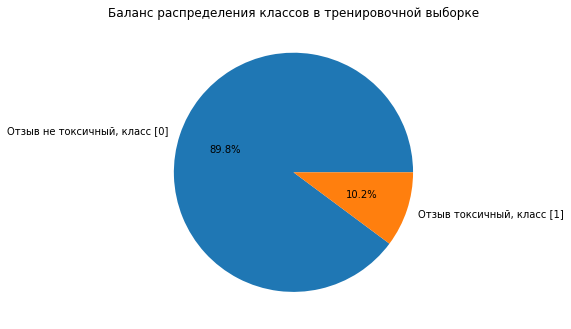

In [48]:
#Проверим распределение класов в тренировочной выборке.

target_train.value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], 
                                               legend=False, autopct='%1.1f%%',
                                               labels=['Отзыв не токсичный, класс [0]',
                                                       'Отзыв токсичный, класс [1]'])
plt.title('Баланс распределения классов в тренировочной выборке')
plt.ylabel('')
plt.show()

Явный дисбаланс классов. Учтем это при постороении моделей и используем class_weight= 'balanced'

Переведем тексты в векторный формат с помощью TF-IDF меры. В этой модели вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

## Обучение

In [49]:
# для обощения результатов
results = []

In [50]:
# функция для постороения матрицы ошибок 
def matrix(model, test, target):
    fig, ax = plt.subplots(figsize=(6,6)) 
    plot_confusion_matrix(model, test, target, cmap=plt.cm.OrRd, ax=ax);

In [51]:
# функция для вычисления  F1:
def F1(target, predicted):
    return f1_score(target, predicted) 

In [52]:
score = make_scorer(F1, greater_is_better = True) 
CV = 5

### Продожлим исследование без учета дисбаланса классов

#### LogisticRegression

In [53]:
pipeline_lr = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('model_lr', LogisticRegression(random_state=STATE))
])

In [54]:
param_grid_lr = {
    'model_lr__C': [4,10],
    'model_lr__class_weight': ['balanced', None]
}

In [55]:
grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr,cv=CV,scoring= score)

In [56]:
%%time
grid_search_lr.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                                       ('model_lr',
                                        LogisticRegression(random_state=123))]),
             param_grid={'model_lr__C': [4, 10],
                         'model_lr__class_weight': ['balanced', None]},
             scoring='f1')

In [62]:
results.append({'Модель': 'LogisticRegression', 
                'Параметры':grid_search_lr.best_params_, 
                'F1': grid_search_lr.best_score_})

pd.DataFrame(results)

,Модель,Параметры,F1
0,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...","(1, 2)"
1,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292


#### DecisionTreeClassifier

In [63]:
# зададим параметры для моделей
parameters_dt = {'model_dt__max_depth':[100,150,200]}
                #'model_dt__class_weight':['balanced']}


In [64]:
pipeline_dt = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('model_dt', DecisionTreeClassifier(random_state=STATE, class_weight = 'balanced'))
])

In [65]:
gs_dt = GridSearchCV(pipeline_dt, parameters_dt, scoring= score, cv=CV)

In [66]:
%%time
gs_dt.fit(features_train, target_train)    

CPU times: user 19min 14s, sys: 984 ms, total: 19min 15s
Wall time: 19min 16s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                                       ('model_dt',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=123))]),
             param_grid={'model_dt__max_depth': [100, 150, 200]},
             scoring=make_scorer(F1))

In [67]:
results.append({'Модель': 'DecisionTreeClassifier', 
                'Параметры':gs_dt.best_params_, 
                'F1': gs_dt.best_score_})

pd.DataFrame(results)

,Модель,Параметры,F1
0,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...","(1, 2)"
1,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
2,DecisionTreeClassifier,{'model_dt__max_depth': 200},0.663434


#### CatBoost Classifier

In [87]:
# зададим параметры для моделей
parameters_cat = {'model_cat__depth':[3,6],
                  'model_cat__iterations':[300]
                 #'eval_metric':['F1']
                 }

In [88]:
pipeline_cat = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('model_cat', CatBoostClassifier(random_state=STATE))
])

In [89]:
gs_cat = GridSearchCV(pipeline_cat, parameters_cat, scoring= score, cv=CV)

In [91]:
%%time
gs_cat.fit(features_train, target_train)

Learning rate set to 0.235374
0:	learn: 0.4844377	total: 904ms	remaining: 4m 30s
1:	learn: 0.3769876	total: 1.67s	remaining: 4m 9s
2:	learn: 0.3203486	total: 2.44s	remaining: 4m 2s
3:	learn: 0.2884626	total: 3.21s	remaining: 3m 57s
4:	learn: 0.2688187	total: 4.02s	remaining: 3m 57s
5:	learn: 0.2559956	total: 4.79s	remaining: 3m 54s
6:	learn: 0.2465013	total: 5.63s	remaining: 3m 55s
7:	learn: 0.2398870	total: 6.43s	remaining: 3m 54s
8:	learn: 0.2359240	total: 7.33s	remaining: 3m 57s
9:	learn: 0.2316866	total: 8.13s	remaining: 3m 55s
10:	learn: 0.2283006	total: 8.88s	remaining: 3m 53s
11:	learn: 0.2256884	total: 9.63s	remaining: 3m 51s
12:	learn: 0.2232321	total: 10.4s	remaining: 3m 50s
13:	learn: 0.2209754	total: 11.2s	remaining: 3m 49s
14:	learn: 0.2190595	total: 12.1s	remaining: 3m 49s
15:	learn: 0.2165732	total: 12.8s	remaining: 3m 47s
16:	learn: 0.2130933	total: 13.7s	remaining: 3m 47s
17:	learn: 0.2114511	total: 14.5s	remaining: 3m 46s
18:	learn: 0.2099124	total: 15.2s	remaining: 3

KeyboardInterrupt: 

In [ ]:
results.append({'Модель': 'CatBoostClassifier', 
                'Параметры':gs_cat.best_params_, 
                'F1': gs_cat.best_score_})

pd.DataFrame(results)

Для всех заявленных в работу моделей подобранны наилушие параметры. Перейдем к анализу результатов.

### Проверим на тестовой выборке модель показавшую лучший результат F1 с лучшими гипперпараметрами.

In [92]:
pd.DataFrame(results)

,Модель,Параметры,F1
0,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...","(1, 2)"
1,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
2,DecisionTreeClassifier,{'model_dt__max_depth': 200},0.663434


Этой моделью стала LogisticRegression

In [98]:
test_predictions_lr = grid_search_lr.predict(features_test)

In [101]:
results.append({'Модель': 'LogisticRegression', 
                'Параметры':grid_search_lr.best_params_, 
                'F1': F1(target_test, test_predictions_lr)})

pd.DataFrame(results)

,Модель,Параметры,F1
0,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...","(1, 2)"
1,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
2,DecisionTreeClassifier,{'model_dt__max_depth': 200},0.663434
3,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
4,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.781239


Результат контрольной метрики F1 = 0.781239, что немного выше на обучающей выборке

Проверим модель на адекватность

In [102]:
dummy_model = DummyClassifier(strategy ='uniform')
dummy_model.fit(features_train, target_train)

test_predictions_dammy = dummy_model.predict(features_test)

In [103]:
results.append({'Модель': 'DummyClassifier', 
                'Параметры':{'strategy':'uniform'
                            }, 
                'F1': round(F1(target_test, test_predictions_dammy),2)})

pd.DataFrame(results)

,Модель,Параметры,F1
0,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...","(1, 2)"
1,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
2,DecisionTreeClassifier,{'model_dt__max_depth': 200},0.663434
3,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.779292
4,LogisticRegression,"{'model_lr__C': 10, 'model_lr__class_weight': ...",0.781239
5,DummyClassifier,{'strategy': 'uniform'},0.16


Показатель F1 у DummyClassifier очень мал, значит наша модель прошла проверку.

## Выводы

В представленном датасете 159292 строк и 3 столбца. После предварителой обработки был удален столбец содержащий не информативные признаки. Текст столбца содержащего комментарии пользователей был лематизирован,приведен в векторный формат с учетом стоп-стов. Выявленные пустые строки были удалены. На этом этапе был выявлен явный дисбаланс классов. При постороении моделей был использован class_weight ='balanced'.

Для задачи классификации было решено использовать три модели:
- LogistiсRegression
- DecisionTreeClassifier
- CatBoostClassifier

Из трех моделей только LogisticRegression удовлетворяет условиям проекта - метрика F1 не меньше 0.75. После проверки ее качества на тестовой выборке она так же прошла проверку на адекватность  константной моделью.

Теоретически возможно добиться лучших показателей метрики у CatBoostClassifier, но у данной модели очень большое время обучения, что опять склоняет наш выбор в сторону LogisticRegression.

<s>Отдельного внимания заслуживают матрицы ошибок.

Матрица ошибок модели LogisticRegression показала:
 - 1121 ложно отрицательный коментарий ,который будет напрасно отправлен на модерацию
 - 521 комментарий пропущен и принят за положительный
 
Матрица ошибок модели DecisionTreeClassifier показала, что:
 - 647 ложно отрицательный коментарий
 - 997 ложно положительный
 
Матрица ошибок модели CatBoostClassifier показала, что:
 - 214 ложно отрицательный коментарий
 - 1183 ложно положительный
 
Таким образом  LogisticRegression даст большую нагрузку на модераторов контента и пропустит меньше всего токсичных комментариев. <\s>